### 학습하는 패턴
꼬리 모양, 무늬, 포즈, 수염 

### custom dataset

In [36]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import os

class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir= img_dir
        self.transform= transform

    def __len__(self):
        img_list= os.listdir(self.img_dir)
        return len(img_list)
    
    def __getitem__(self, index):
        img_list= os.listdir(self.img_dir)
        base_path= self.img_dir
        img_path = os.path.join(base_path, img_list[index])
        img = Image.open(img_path).convert('RGB')
        
        if 'dog' in img_list[index]:
            label= 0
        else:
            label= 1

        transformed_img= self.transform(image=np.array(img))['image']
        

        return transformed_img, label

### transform, Dataloader

In [37]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader


train_transforms = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),
    ], p=1.0),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(224, 224),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(224, 224),
    ToTensorV2()
])






In [12]:
import torchvision
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
])

In [38]:
train_dog_dataset = CustomDataSet("C:/Users/USER/Downloads/data/training_set/dogs", transform=train_transforms)
train_cat_dataset = CustomDataSet("C:/Users/USER/Downloads/data/training_set/cats", transform=train_transforms)
valid_dog_dataset = CustomDataSet("C:/Users/USER/Downloads/data/test_set/dogs", transform=val_transforms)
valid_cat_dataset = CustomDataSet("C:/Users/USER/Downloads/data/test_set/cats", transform=val_transforms)

 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])


print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')


number of train dataset : 200
number of valid dataset : 200


In [39]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [40]:
Device='cuda' if torch.cuda.is_available() else 'cpu'
print(Device)

cuda


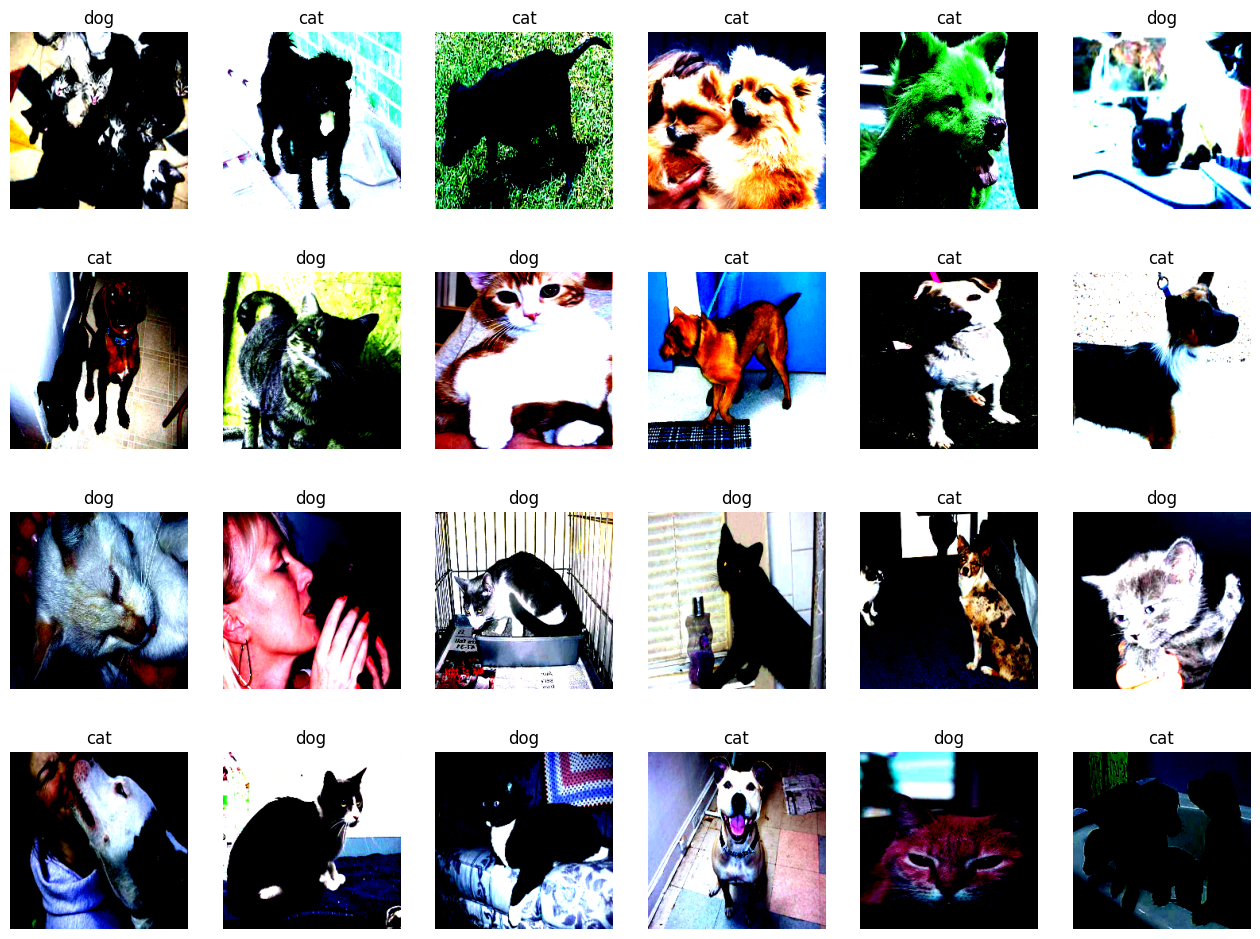

In [41]:
import matplotlib.pyplot as plt
import numpy as np
samples, labels = images, labels = next(iter(train_loader))

classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( 
        	in_channels=3, out_channels=8,
        	kernel_size=3, padding=1
        )
        self.conv2 = nn.Conv2d(
        	in_channels=8, out_channels=16, 
            kernel_size=3, padding=1
        )
        self.activation = nn.GELU()
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1= nn.BatchNorm2d(8)
        self.bn2= nn.BatchNorm2d(16)
        self.dp= nn.Dropout(0.2)
        self.fc1 = nn.Linear(56*56*16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x= self.conv1(x)
        x= self.bn1(x)
        x= self.activation(x)
        x= self.dp(x)
        x= self.pool(x)
        x= self.conv2(x)
        x= self.bn2(x)
        x= self.activation(x)
        x= self.dp(x)
        x= self.pool(x)

        x= x.view(x.size(0), -1)
        x= self.activation(self.fc1(x))
        x= self.activation(self.fc2(x))
        x= self.fc3(x)
        return x

In [43]:
model = CNN().to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): GELU(approximate='none')
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [44]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(Device)
        label = label.to(Device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [45]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(Device)
            label = label.to(Device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [46]:
EPOCHS=10

In [47]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, valid_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/200 (0%)]	Train Loss: 0.696158

[EPOCH: 1], 	Test Loss: 0.0358, 	Test Accuracy: 50.00 % 

Train Epoch: 2 [0/200 (0%)]	Train Loss: 7.306745

[EPOCH: 2], 	Test Loss: 0.0261, 	Test Accuracy: 52.50 % 

Train Epoch: 3 [0/200 (0%)]	Train Loss: 1.575008

[EPOCH: 3], 	Test Loss: 0.0231, 	Test Accuracy: 64.00 % 

Train Epoch: 4 [0/200 (0%)]	Train Loss: 0.865336

[EPOCH: 4], 	Test Loss: 0.0245, 	Test Accuracy: 55.50 % 

Train Epoch: 5 [0/200 (0%)]	Train Loss: 0.475215

[EPOCH: 5], 	Test Loss: 0.0382, 	Test Accuracy: 51.50 % 

Train Epoch: 6 [0/200 (0%)]	Train Loss: 0.622219

[EPOCH: 6], 	Test Loss: 0.0250, 	Test Accuracy: 60.00 % 

Train Epoch: 7 [0/200 (0%)]	Train Loss: 0.695602

[EPOCH: 7], 	Test Loss: 0.0257, 	Test Accuracy: 58.50 % 

Train Epoch: 8 [0/200 (0%)]	Train Loss: 0.408050

[EPOCH: 8], 	Test Loss: 0.0253, 	Test Accuracy: 60.00 % 

Train Epoch: 9 [0/200 (0%)]	Train Loss: 0.337884

[EPOCH: 9], 	Test Loss: 0.0278, 	Test Accuracy: 57.50 % 

Train Epoch: 10 [0/200 (0%)]